# NETSI Special Topic: Causal Analysis
## Jupyter notebook on Fisher's exact inference

In this notebook, we are going to perform Fisher's exact inference. With the advancement of computational capacity, Fisher's exact inference is quickly becoming an attractive alternative to Neyman's superpopulation approach. Let's see how it works!

For this exercise, we will use a clinical trial study by van der Leij et al. (2019). The research question of this paper is whether providing hiding box to sheltered cats makes them be less stressed and lose less weight.
* [Article link](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0223492)
* [Data link](https://dataverse.nl/dataset.xhtml?persistentId=hdl:10411/T8LKML)

Assignment mechanism is not exactly specified in the article. Here, we will assume that it is stratified by gender. (Male: 6 treated out of 11; Female: 6 treated out of 12)

In [7]:
## Initial setting
set.seed(15)
library(tidyverse)
library(ggmap)
library(dplyr) # Easier data manipulation
library(lfe) # For OLS

## Download data
df <- read.table("https://raw.github.com/DongheeJo/causal-analysis-netsi/master/data/HidingBox/data.txt",
    sep="\t",header=TRUE)

## Sort by gender
df <- df[order(df$gender,df$id),]
rownames(df) <- 1:nrow(df)

## In order to avoid dealing with missing data, let's plug in age = 6 for NA
# (of course in real research you can't do this)
df[8,'age']<-6

**1) Let's first calculate Fisher's exact p-value**

In [8]:
## Calculate (quite intiutive) test statistic of choice: weighted average of T_dif for males and females
# Some discussion can be found in Section 9.3 of Imbens and Rubin
df_grp <- df %>% add_count(gender) %>% group_by(gender, treat) %>%
    summarize(stress12 = mean(stress12), weight12 = mean(weight12), count = mean(n)) %>%
    arrange(desc(gender), desc(treat))
# df_grp[1,]: gender 1 treat 1
# df_grp[2,]: gender 1 treat 0
# df_grp[3,]: gender 0 treat 1
# df_grp[4,]: gender 0 treat 0
T_stress <- abs(
    df_grp[1,'count']*(df_grp[1,'stress12']-df_grp[2,'stress12']) +
    df_grp[3,'count']*(df_grp[3,'stress12']-df_grp[4,'stress12'])
    ) %>% pull()
T_weight <- abs(
    df_grp[1,'count']*(df_grp[1,'weight12']-df_grp[2,'weight12']) +
    df_grp[3,'count']*(df_grp[3,'weight12']-df_grp[4,'weight12'])
    ) %>% pull()

In [3]:
df_grp
T_stress
T_weight

gender,treat,stress12,weight12,count
1,1,1.932045,-5.028975,12
1,0,2.188712,-5.311478,12
0,1,1.848933,-7.660270,11
0,0,2.251111,-10.595823,11


[1] 7.503966

[1] 35.68112

In [9]:
## For complete test, how many re-randomization do we need?
num_m <- table(df$gender)[["0"]][1]
num_f <- table(df$gender)[["1"]][1]
choose(num_f,6)*choose(num_m,6)

[1] 426888

In [15]:
## Instead, let's re-randomize num_sim times and get distribution of T_dif
num_sim = 10000
sim_T <- as.data.frame(matrix(0, ncol = 2, nrow = num_sim))
names(sim_T) <- c("T_stress","T_weight")

for (s in 1:num_sim) {
    sim_df <- df
    sims <- data.frame("s" = 1:num_sim)
    a <- sample(1:num_m, 6)
    b <- sample((num_m+1):(num_m+num_f),6)
    sim_df$treat <- 0
    sim_df$treat[c(a,b)] <- 1
    sim_df_grp <- sim_df %>% add_count(gender) %>% group_by(gender, treat) %>%
        summarize(stress12 = mean(stress12), weight12 = mean(weight12), count = mean(n)) %>%
        arrange(desc(gender), desc(treat))
    sim_T$T_stress[s] <- abs(
        sim_df_grp[1,'count']*(sim_df_grp[1,'stress12']-sim_df_grp[2,'stress12']) +
        sim_df_grp[3,'count']*(sim_df_grp[3,'stress12']-sim_df_grp[4,'stress12'])
        ) %>% pull()
    sim_T$T_weight[s] <- abs(
        sim_df_grp[1,'count']*(sim_df_grp[1,'weight12']-sim_df_grp[2,'weight12']) +
        sim_df_grp[3,'count']*(sim_df_grp[3,'weight12']-sim_df_grp[4,'weight12'])
        ) %>% pull()
}

[1] "P-value for stress:  0.001"


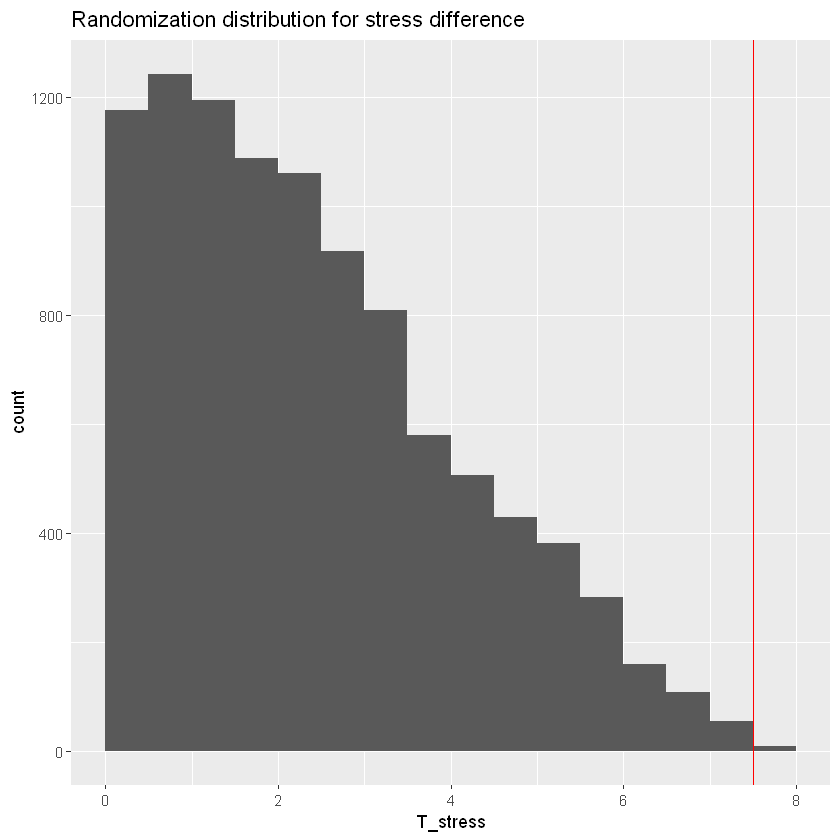

[1] "P-value for weight:  0.4118"


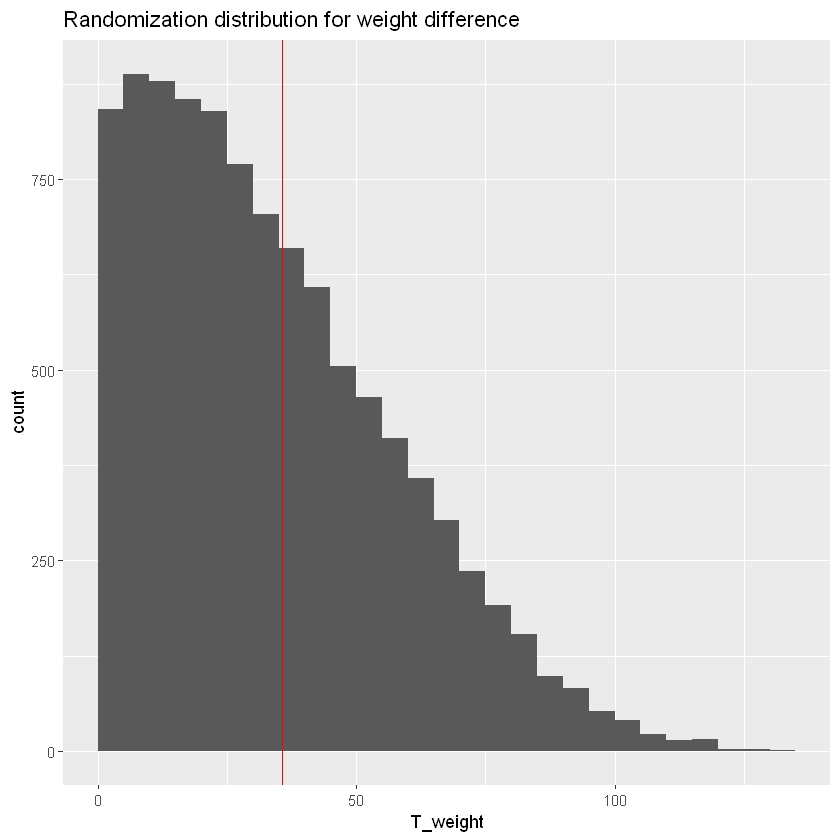

In [16]:
## Draw randomization distribution of our test statistics and calculate p_value.

# 1. Stress
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_stress), boundary=0, binwidth=0.5) +
    geom_vline(xintercept=T_stress, color="red") +
    ggtitle("Randomization distribution for stress difference")
p_stress <- sum(sim_T$T_stress >= T_stress)/num_sim
print(paste("P-value for stress: ",p_stress))

# 2. weight
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_weight), boundary=0, binwidth=5) +
    geom_vline(xintercept=T_weight, color="red") +
    ggtitle("Randomization distribution for weight difference")
p_weight <- sum(sim_T$T_weight >= T_weight)/num_sim
print(paste("P-value for weight: ",p_weight))

**2) How to take into account covariates?**

We can choose regression coefficient (with all the pre-experiment covariates as controls) as our test statistic.

In [33]:
## Let's re-randomize num_sim times and get distribution of T_coef
num_sim = 1000
sim_T <- as.data.frame(matrix(0, ncol = 2, nrow = num_sim))
names(sim_T) <- c("T_stress","T_weight")

for (s in 1:num_sim) {
    sim_df <- df
    sims <- data.frame("s" = 1:num_sim)
    a <- sample(1:num_m, 6)
    b <- sample((num_m+1):(num_m+num_f),6)
    sim_df$treat <- 0
    sim_df$treat[c(a,b)] <- 1
    sim_T$T_stress[s] <- coef(summary(felm(stress12 ~ treat + age | gender, data=sim_df)))["treat",1]
    sim_T$T_weight[s] <- coef(summary(felm(weight12 ~ treat + age | gender, data=sim_df)))["treat",1]
}

[1] "P-value for stress:  0.001"


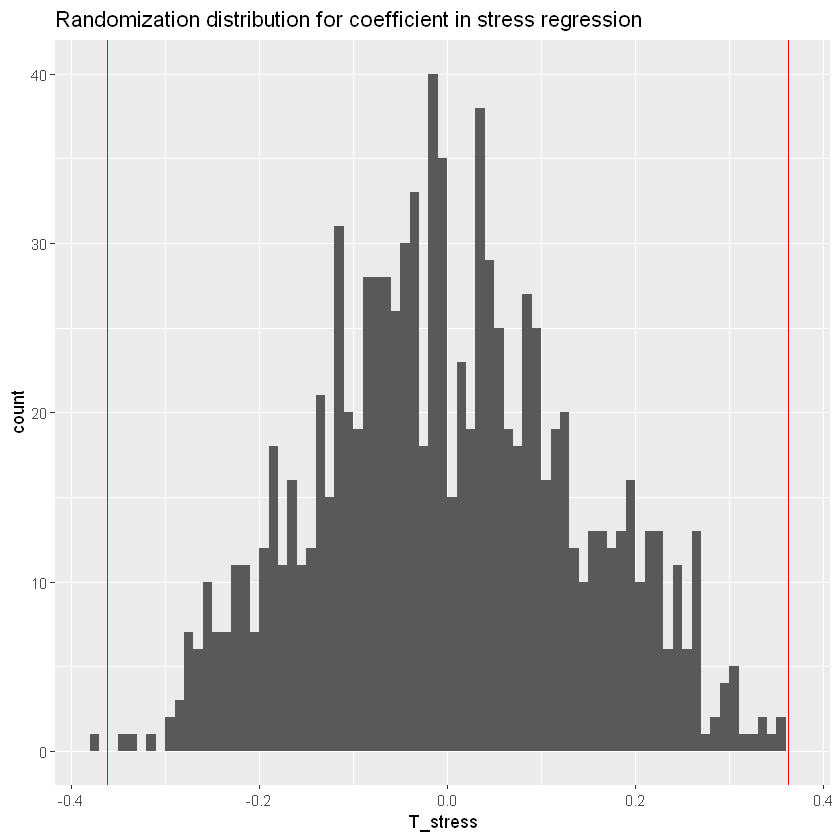

[1] "P-value for weight:  0.203"


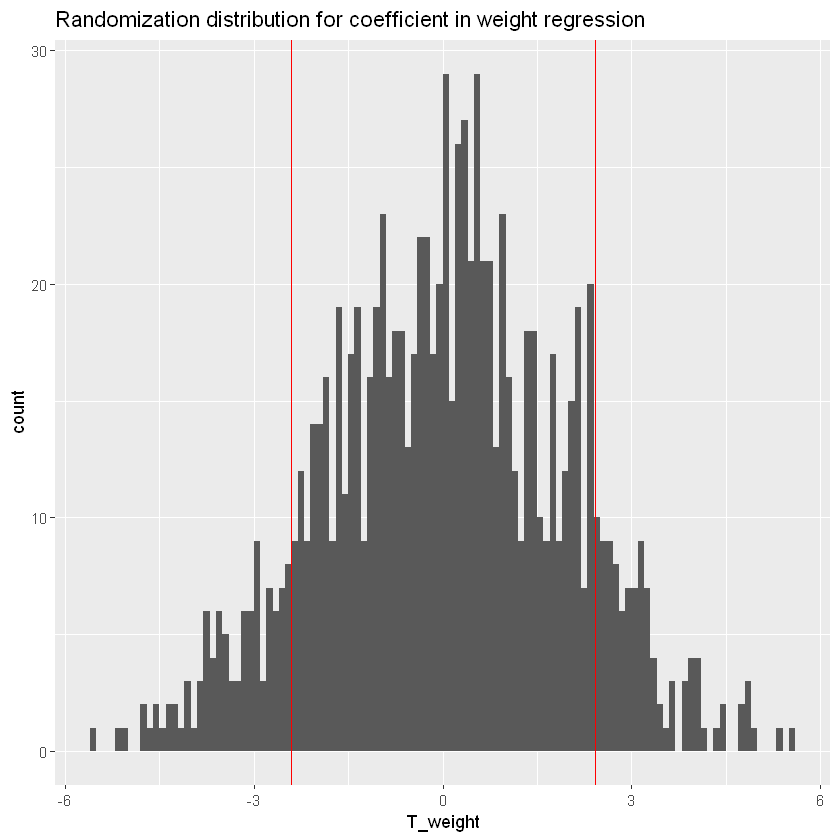

In [34]:
## Draw randomization distribution of our test statistics and calculate p_value.

# 1. Stress
T_stress <- coef(summary(felm(stress12 ~ treat + age | gender, data=df)))["treat",1]
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_stress), boundary=0, binwidth=0.01) +
    geom_vline(xintercept=T_stress, color="red") +
    geom_vline(xintercept=-T_stress, color="red") +
    ggtitle("Randomization distribution for coefficient in stress regression")
p_stress <- sum(abs(sim_T$T_stress) >= abs(T_stress))/num_sim
print(paste("P-value for stress: ",p_stress))

# 2. weight
T_weight <- coef(summary(felm(weight12 ~ treat + age | gender, data=df)))["treat",1]
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_weight), boundary=0, binwidth=0.1) +
    geom_vline(xintercept=T_weight, color="red") +
    geom_vline(xintercept=-T_weight, color="red") +
    ggtitle("Randomization distribution for coefficient in weight regression")
p_weight <- sum(abs(sim_T$T_weight) >= abs(T_weight))/num_sim
print(paste("P-value for weight: ",p_weight))

**3) Constructing confidence interval**

In [37]:
## Stress: what is the minimum/maximum uniform treatment effect C that we stop
#   rejecting the null of tau_i = C for all i at 95% confidence interval?
stress_C <- seq(from=-1,to=0,by=0.025)
weight_C <- seq(from=-3,to=7,by=0.25)
num_sim = 100
cnames <- c()
sim_T <- as.data.frame(matrix(0, ncol = 2*length(stress_C), nrow = num_sim))
for (cnum in 1:length(stress_C)) {
    cnames <- c(cnames,paste("T_stress_s",cnum,sep=""))
    cnames <- c(cnames,paste("T_weight_s",cnum,sep=""))
}
names(sim_T) <- cnames

for (s in 1:num_sim) {
    
    # re-randomize
    a <- sample(1:num_m, 6)
    b <- sample((num_m+1):(num_m+num_f),6)
    df$sim_treat <- 0
    df$sim_treat[c(a,b)] <- 1
    
    for (cnum in 1:length(stress_C)) {
        # calculate imputed value of Y_i[0]
        c_stress <- stress_C[cnum]
        c_weight <- weight_C[cnum]
        df$stress12_s <- df$stress12
        df$weight12_s <- df$weight12
        df[(df$treat==1)&(df$sim_treat==0),"stress12_s"] <- df[(df$treat==1)&(df$sim_treat==0),"stress12"] - c_stress
        df[(df$treat==0)&(df$sim_treat==1),"stress12_s"] <- df[(df$treat==0)&(df$sim_treat==1),"stress12"] + c_stress
        df[(df$treat==1)&(df$sim_treat==0),"weight12_s"] <- df[(df$treat==1)&(df$sim_treat==0),"weight12"] - c_weight
        df[(df$treat==0)&(df$sim_treat==1),"weight12_s"] <- df[(df$treat==0)&(df$sim_treat==1),"weight12"] + c_weight
        # Run regressions
        sim_T[s,paste("T_stress_s",cnum,sep="")] <- coef(summary(felm(stress12_s ~ sim_treat + age | gender, data=df)))["sim_treat",1]
        sim_T[s,paste("T_weight_s",cnum,sep="")] <- coef(summary(felm(weight12_s ~ sim_treat + age | gender, data=df)))["sim_treat",1]
    }
    
    # Monitoring (doesn't work right now; reported after everything is finished)
    if (s%%100 == 0) {
        print(paste("Finished simulation",s))
    }
}

[1] "Finished simulation 100"


In [36]:
sim_T$T_stress_s41

NULL

In [40]:
## first check whether the p-value for C=0 is similar to what we found above.
# Note that we calculate p-value and confidence interval in the same simulation.
stress_C[41]
weight_C[13]
sum(abs(sim_T$T_stress_s41) >= abs(T_stress))/num_sim
sum(abs(sim_T$T_weight_s13) >= abs(T_weight))/num_sim

[1] 0

[1] 0

[1] 0

[1] 0.15

In [41]:
## Summarize simulated statistics for each C and create confidence interval
pvals <- as.data.frame(matrix(0, ncol = 6, nrow = length(stress_C)))
names(pvals) <- c("C_stress","pval_stress","CI_stress_95","C_weight","pval_weight","CI_weight_95")
for (cnum in 1:length(stress_C)) {
    pvals[cnum,'C_stress'] <- stress_C[cnum]
    pvals[cnum,'pval_stress'] <- sum(abs(sim_T[paste("T_stress_s",cnum,sep="")]-stress_C[cnum]) 
                                     >= abs(T_stress-stress_C[cnum]))/num_sim
    pvals[cnum,'C_weight'] <- weight_C[cnum]
    pvals[cnum,'pval_weight'] <- sum(abs(sim_T[paste("T_weight_s",cnum,sep="")]-weight_C[cnum]) 
                                     >= abs(T_weight-weight_C[cnum]))/num_sim

}
pvals$CI_stress_95 <- (pvals$pval_stress >= 0.05)
pvals$CI_weight_95 <- (pvals$pval_weight >= 0.05)
pvals
# Note: to be conservative, add one more top and bottom.

C_stress,pval_stress,CI_stress_95,C_weight,pval_weight,CI_weight_95
-1.000,0.00,FALSE,-3.00,0.00,FALSE
-0.975,0.00,FALSE,-2.75,0.00,FALSE
-0.950,0.00,FALSE,-2.50,0.00,FALSE
-0.925,0.00,FALSE,-2.25,0.02,FALSE
-0.900,0.00,FALSE,-2.00,0.02,FALSE
-0.875,0.00,FALSE,-1.75,0.02,FALSE
-0.850,0.00,FALSE,-1.50,0.03,FALSE
-0.825,0.00,FALSE,-1.25,0.06,TRUE
-0.800,0.00,FALSE,-1.00,0.06,TRUE
-0.775,0.00,FALSE,-0.75,0.08,TRUE


In [42]:
## Compare with regression confidence interval
st <- felm(stress12 ~ treat + age | gender, data=df)
wt <- felm(weight12 ~ treat + age | gender, data=df)
confint(st, "treat")
confint(wt, "treat")

,2.5 %,97.5 %
treat,-0.6135744,-0.1108078


,2.5 %,97.5 %
treat,-1.638132,6.468515


Now with all possible assignments:

In [10]:
num_sim = choose(num_f,6)*choose(num_m,6)
sim_T <- as.data.frame(matrix(0, ncol = 2, nrow = num_sim))
names(sim_T) <- c("T_stress","T_weight")

assignmentsM <- combn(1:num_m, 6)
assignmentsF <- combn(num_m+1:num_f, 6)

i=1
for (assM in 1:ncol(assignmentsM)) {
        for (assF in 1:ncol(assignmentsF)) {
            sim_df <- df
            sims <- data.frame("s" = 1:num_sim)
            sim_df$treat <- 0
            sim_df$treat[c(assignmentsM[,assM],(assignmentsF[,assF]))] <- 1
            sim_T$T_stress[i] <- coef(summary(felm(stress12 ~ treat + age | gender, data=sim_df)))["treat",1]
            sim_T$T_weight[i] <- coef(summary(felm(weight12 ~ treat + age | gender, data=sim_df)))["treat",1]
            i <- i+1            
    }
}

[1] "P-value for stress:  0.000632484398718165"


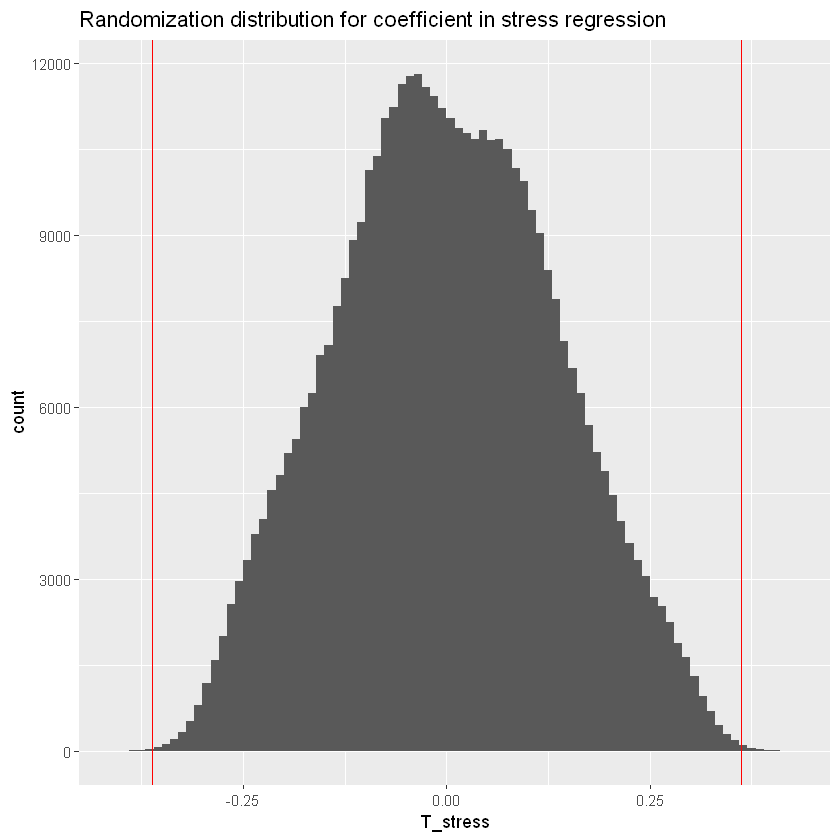

[1] "P-value for weight:  0.212336725323738"


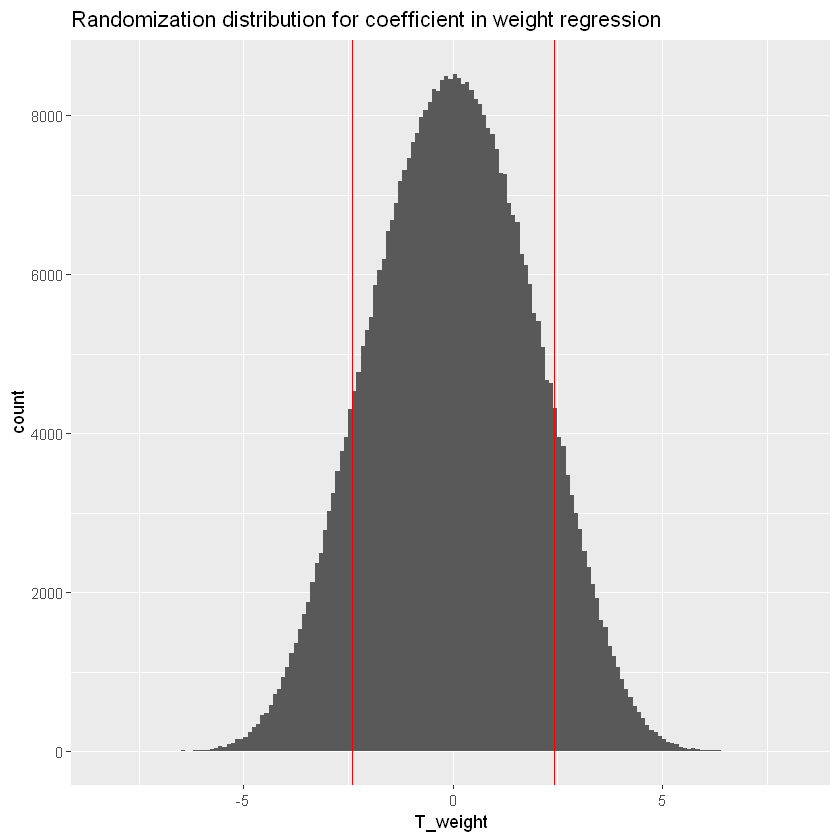

In [11]:
## Draw randomization distribution of our test statistics and calculate p_value.

# 1. Stress
T_stress <- coef(summary(felm(stress12 ~ treat + age | gender, data=df)))["treat",1]
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_stress), boundary=0, binwidth=0.01) +
    geom_vline(xintercept=T_stress, color="red") +
    geom_vline(xintercept=-T_stress, color="red") +
    ggtitle("Randomization distribution for coefficient in stress regression")
p_stress <- sum(abs(sim_T$T_stress) >= abs(T_stress))/num_sim
print(paste("P-value for stress: ",p_stress))

# 2. weight
T_weight <- coef(summary(felm(weight12 ~ treat + age | gender, data=df)))["treat",1]
ggplot(data=sim_T) +
    geom_histogram(mapping=aes(x=T_weight), boundary=0, binwidth=0.1) +
    geom_vline(xintercept=T_weight, color="red") +
    geom_vline(xintercept=-T_weight, color="red") +
    ggtitle("Randomization distribution for coefficient in weight regression")
p_weight <- sum(abs(sim_T$T_weight) >= abs(T_weight))/num_sim
print(paste("P-value for weight: ",p_weight))